In [1]:
# !pip install sklearn_pandas

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
import skimage
import sklearn
from sklearn import linear_model
import sklearn.decomposition
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
import sklearn.ensemble
import sklearn_pandas


%matplotlib inline

PATH = Path('../..').resolve()


# general hyperparms
validation_pct = 0.2
seed = 12345

# RF
num_trees = 100

# pca
n_components = 16
batch_size = 200



In [3]:
slope = lambda y, p: ((y - y.mean())*(p - p.mean())).sum() / ((y - y.mean())**2).sum()

# Load targets & pixels

In [4]:
df = pd.read_csv(f'{PATH}/data/a40-SDSS_gas-frac.csv')

In [5]:
y = df.logfgas.to_numpy()

In [6]:
# this takes up 1 GB of memory on disk... (~2 min)
# X = np.array([np.array(Image.open(f'{PATH}/images-OC/{o}.jpg')).flatten() for o in df.AGCNr])
# np.save(f'{PATH}/data/raveled_a40A_images.npy', X)

In [7]:
X = np.load(f'{PATH}/data/raveled_a40A_images.npy')

# Linear model (downsized) 

In [8]:
X = X.reshape((len(X), 224, 224, 3))

In [9]:
# 7x7 average pooling
X_mini = skimage.measure.block_reduce(X, (1, 7, 7, 1), np.mean)

In [10]:
X.shape, X_mini.shape

((7399, 224, 224, 3), (7399, 32, 32, 3))

In [11]:
X_mini = X_mini.reshape(len(y), -1)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_mini, y, test_size=0.2, random_state=seed)

In [13]:
%%time

reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)

p_test = reg.predict(X_test)

CPU times: user 17.1 s, sys: 196 ms, total: 17.3 s
Wall time: 4.46 s


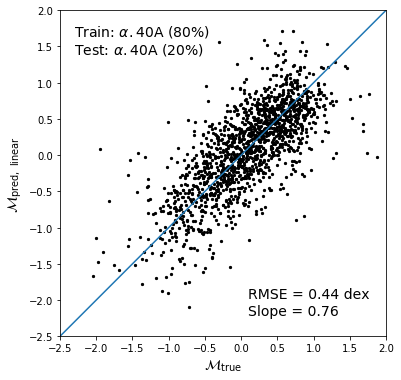

In [14]:
plt.figure(figsize=(6, 6))

plt.scatter(y_test, p_test, c='k', s=5)

plt.plot([-3, 3], [-3, 3])
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, r'Train: $\alpha.40$A (80%)' + '\n' +r'Test: $\alpha.40$A (20%)', fontsize=14)
plt.text(0.1, -2.2, f'RMSE = {((p_test - y_test)**2).mean()**0.5:.2f} dex\n' + f'Slope = {slope(y_test, p_test):.2f}', fontsize=14)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred,\ linear}$', fontsize=14);

plt.savefig(f'{PATH}/results/simpler-models/Linear-no-PCA_a40A_train-test.pdf')

## Repeat with xGASS

In [15]:
xg = pd.read_csv(f'{PATH}/data/xGASS_representative_sample.csv')
X_xgass = np.array([np.array(Image.open(f'{PATH}/images-xGASS/{o}.jpg')) for o in xg.GASS])

X_mini = skimage.measure.block_reduce(X_xgass, (1, 7, 7, 1), np.mean)
y = xg.lgGF

In [16]:
X_mini = X_mini.reshape(len(y), -1)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_mini, y, test_size=validation_pct, random_state=seed)

In [18]:
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)

p_test = reg.predict(X_test)

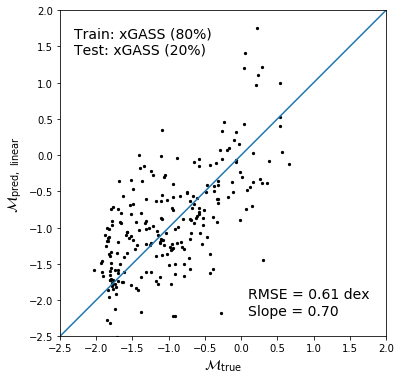

In [19]:
plt.figure(figsize=(6, 6))

plt.scatter(y_test, p_test, c='k', s=5)

plt.plot([-3, 3], [-3, 3])
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, r'Train: xGASS (80%)' + '\n' +r'Test: xGASS (20%)', fontsize=14)
plt.text(0.1, -2.2, f'RMSE = {((p_test - y_test)**2).mean()**0.5:.2f} dex\n' + f'Slope = {slope(y_test, p_test):.2f}', fontsize=14)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred,\ linear}$', fontsize=14);

plt.savefig(f'{PATH}/results/simpler-models/Linear-no-PCA_xGASS_train-test.pdf')

# PCA x Random Forest regression

## Compress using PCA

In [20]:
pca = sklearn.decomposition.IncrementalPCA(n_components=n_components, batch_size=batch_size)

In [21]:
X = np.load(f'{PATH}/data/raveled_a40A_images.npy')

y = df.logfgas.to_numpy()

In [22]:
# scales like O(bs * n^2) where n=150,000 is original num of pixels
# inverting these gigantic matrices is a pain... (~2 min)

# pca.fit(X)
# X_pca = pca.transform(X)


In [23]:
# np.save(f'{PATH}/data/raveled_a40A_images-PCA.npy', X_pca)
X_pca = np.load(f'{PATH}/data/raveled_a40A_images-PCA.npy')

## Train RF

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=validation_pct, random_state=seed)

In [25]:
X_train.shape, y_train.shape

((5919, 16), (5919,))

In [26]:
rf = sklearn.ensemble.RandomForestRegressor(n_estimators=num_trees, random_state=seed)

In [27]:
# this is somewhat slow....
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=12345,
                      verbose=0, warm_start=False)

In [28]:
p_test = rf.predict(X_test)

In [29]:
rmse = ((p_test - y_test)**2).mean()**0.5
rmse

0.31201420797427

In [30]:
# sanity check
slope(np.arange(10), np.arange(10)), slope(np.arange(10), np.arange(10)[::-1])

(1.0, -1.0)

In [31]:
slope(y_test, p_test)

0.7054343874837188

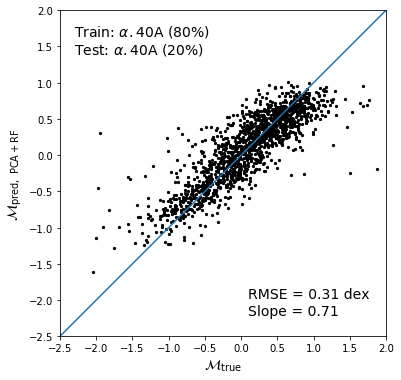

In [32]:
plt.figure(figsize=(6, 6))

plt.scatter(y_test, p_test, c='k', s=5)

plt.plot([-3, 3], [-3, 3])
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, r'Train: $\alpha.40$A (80%)' + '\n' +r'Test: $\alpha.40$A (20%)', fontsize=14)
plt.text(0.1, -2.2, f'RMSE = {((p_test - y_test)**2).mean()**0.5:.2f} dex\n' + f'Slope = {slope(y_test, p_test):.2f}', fontsize=14)
plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred,\ PCA+RF}$', fontsize=14);

plt.savefig(f'{PATH}/results/simpler-models/RF_a40_train-test.pdf')

# xGASS Train/test (plus re-fit using custom PCA)

In [33]:
xg = pd.read_csv(f'{PATH}/data/xGASS_representative_sample.csv')

X_xgass = np.array([np.array(Image.open(f'{PATH}/images-xGASS/{o}.jpg')).flatten() for o in xg.GASS])
y_xg = xg.lgGF

In [34]:
pca = sklearn.decomposition.IncrementalPCA(n_components=n_components, batch_size=batch_size)

X_xgass_pca = pca.fit_transform(X_xgass)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_xgass_pca, y_xg, test_size=validation_pct, random_state=seed)

In [36]:
rf = sklearn.ensemble.RandomForestRegressor(n_estimators=num_trees, random_state=seed)

rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=12345,
                      verbose=0, warm_start=False)

In [37]:
p_test = rf.predict(X_test)

In [38]:
rmse = ((y_test - p_test)**2).mean()**0.5
rmse

0.4069568300289398

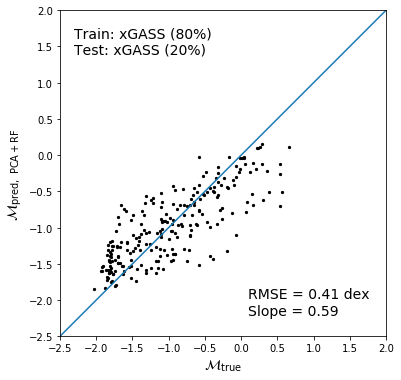

In [39]:
plt.figure(figsize=(6, 6))

plt.scatter(y_test, p_test, c='k', s=5)

plt.plot([-3, 3], [-3, 3])
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, r'Train: xGASS (80%)' + '\n' +r'Test: xGASS (20%)', fontsize=14)
plt.text(0.1, -2.2, f'RMSE = {((p_test - y_test)**2).mean()**0.5:.2f} dex\n' + f'Slope = {slope(y_test, p_test):.2f}', fontsize=14)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred,\ PCA+RF}$', fontsize=14);


plt.savefig(f'{PATH}/results/simpler-models/RF_xGASS_train-test.pdf')

# Combined $\alpha.40$ and xGASS train/test

In [40]:
X = np.load(f'{PATH}/data/raveled_a40A_images.npy')

In [41]:
X.shape, X_xgass.shape

((7399, 150528), (1179, 150528))

In [42]:
X_combined = np.vstack([X, X_xgass])
X_combined.shape

(8578, 150528)

In [43]:
y_combined = np.hstack([df.logfgas.to_numpy(), xg.lgGF.to_numpy()])
y_combined.shape

(8578,)

In [44]:
%%time
X_combined_pca = pca.fit_transform(X_combined)

CPU times: user 9min 28s, sys: 38.8 s, total: 10min 6s
Wall time: 2min 56s


In [45]:
X_train, X_test, y_train, y_test = train_test_split(X_combined_pca, y_combined, test_size=validation_pct, random_state=seed)

In [46]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=12345,
                      verbose=0, warm_start=False)

In [47]:
p_test = rf.predict(X_test)

In [48]:
rmse = ((p_test - y_test)**2).mean()**0.5
rmse

0.3448389977812641

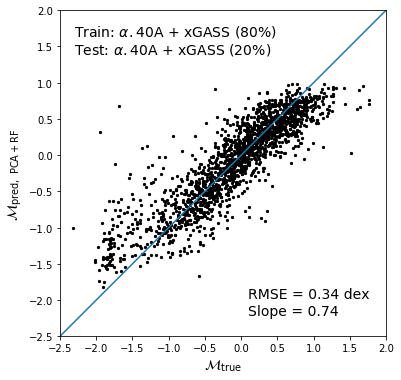

In [49]:
plt.figure(figsize=(6, 6))

plt.scatter(y_test, p_test, c='k', s=5)

plt.plot([-3, 3], [-3, 3])
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, r'Train: $\alpha.40$A + xGASS (80%)' + '\n' +r'Test: $\alpha.40$A + xGASS (20%)', fontsize=14)
plt.text(0.1, -2.2, f'RMSE = {((p_test - y_test)**2).mean()**0.5:.2f} dex\n' + f'Slope = {slope(y_test, p_test):.2f}', fontsize=14)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred,\ PCA+RF}$', fontsize=14);

plt.savefig(f'{PATH}/results/simpler-models/RF_combined_train-test.pdf')

# PCA x polynomials

In [50]:
df = pd.read_csv(f'{PATH}/data/a40-SDSS_gas-frac.csv')

X_pca = np.load(f'{PATH}/data/raveled_a40A_images-PCA.npy')

y = df.logfgas.to_numpy()

In [51]:
poly = PolynomialFeatures(degree=1)

X_lin = poly.fit_transform(X_pca)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X_lin, y, test_size=0.2, random_state=seed)

In [53]:
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)

p_test = reg.predict(X_test)

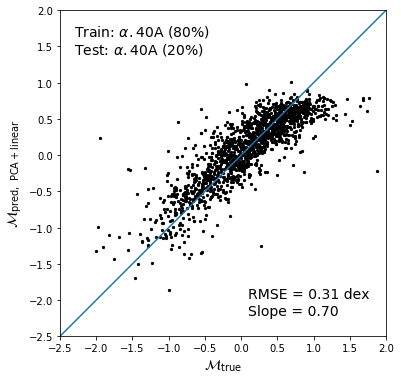

In [54]:
plt.figure(figsize=(6, 6))

plt.scatter(y_test, p_test, c='k', s=5)

plt.plot([-3, 3], [-3, 3])
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, r'Train: $\alpha.40$A (80%)' + '\n' +r'Test: $\alpha.40$A (20%)', fontsize=14)
plt.text(0.1, -2.2, f'RMSE = {((p_test - y_test)**2).mean()**0.5:.2f} dex\n' + f'Slope = {slope(y_test, p_test):.2f}', fontsize=14)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred,\ PCA+linear}$', fontsize=14);

plt.savefig(f'{PATH}/results/simpler-models/Linear_a40A_train-test.pdf')

## Second order poly

In [55]:
poly = PolynomialFeatures(degree=2)

X_poly = poly.fit_transform(X_pca)

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=seed)

In [57]:
reg = linear_model.LinearRegression()

reg.fit(X_train, y_train)

p_test = reg.predict(X_test)

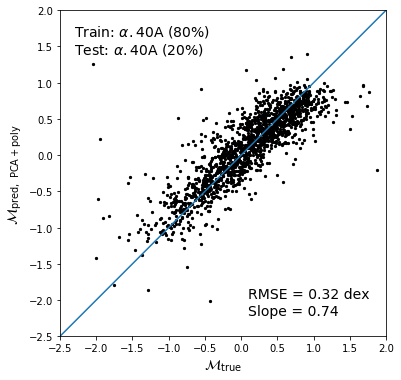

In [58]:
plt.figure(figsize=(6, 6))

plt.scatter(y_test, p_test, c='k', s=5)

plt.plot([-3, 3], [-3, 3])
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.text(-2.3, 1.4, r'Train: $\alpha.40$A (80%)' + '\n' +r'Test: $\alpha.40$A (20%)', fontsize=14)
plt.text(0.1, -2.2, f'RMSE = {((p_test - y_test)**2).mean()**0.5:.2f} dex\n' + f'Slope = {slope(y_test, p_test):.2f}', fontsize=14)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred,\ PCA+poly}$', fontsize=14);

plt.savefig(f'{PATH}/results/simpler-models/Poly_a40A_train-test.pdf')

## Linear (PCA) model with xGASS

In [59]:
xg = pd.read_csv(f'{PATH}/data/xGASS_representative_sample.csv')

X_xgass = np.array([np.array(Image.open(f'{PATH}/images-xGASS/{o}.jpg')).flatten() for o in xg.GASS])

In [60]:
pca = sklearn.decomposition.IncrementalPCA(n_components=n_components, batch_size=batch_size)

In [61]:
X_xgass_pca = pca.fit_transform(X_xgass)

In [62]:
y_xg = xg.lgGF

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X_xgass_pca, y_xg, test_size=validation_pct, random_state=seed)

In [64]:
reg = linear_model.LinearRegression()

reg.fit(X_train, y_train)

p_test = reg.predict(X_test)

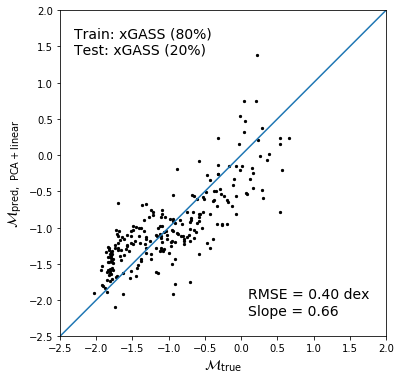

In [68]:
plt.figure(figsize=(6, 6))

plt.scatter(y_test, p_test, c='k', s=5)

plt.text(-2.3, 1.4, r'Train: xGASS (80%)' + '\n' +r'Test: xGASS (20%)', fontsize=14)
plt.text(0.1, -2.2, f'RMSE = {((p_test - y_test)**2).mean()**0.5:.2f} dex\n' + f'Slope = {slope(y_test, p_test):.2f}', fontsize=14)

plt.plot([-3, 3], [-3, 3])
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred,\ PCA+linear}$', fontsize=14);

plt.savefig(f'{PATH}/results/simpler-models/Linear_xGASS_train-test.pdf')

## 2nd order with xGASS

In [66]:
poly = PolynomialFeatures(degree=2)

X_poly = poly.fit_transform(X_xgass_pca)

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X_poly, y_xg, test_size=0.2, random_state=seed)

In [70]:
reg = linear_model.LinearRegression()

reg.fit(X_train, y_train)

p_test = reg.predict(X_test)

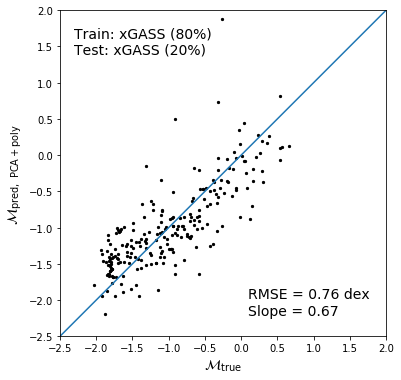

In [71]:
plt.figure(figsize=(6, 6))

plt.scatter(y_test, p_test, c='k', s=5)

plt.text(-2.3, 1.4, r'Train: xGASS (80%)' + '\n' +r'Test: xGASS (20%)', fontsize=14)
plt.text(0.1, -2.2, f'RMSE = {((p_test - y_test)**2).mean()**0.5:.2f} dex\n' + f'Slope = {slope(y_test, p_test):.2f}', fontsize=14)

plt.plot([-3, 3], [-3, 3])
plt.gca().set_aspect('equal')
plt.xlim(-2.5, 2)
plt.ylim(-2.5, 2)

plt.xlabel(r'$\mathcal{M}_{\rm true}$', fontsize=14)
plt.ylabel(r'$\mathcal{M}_{\rm pred,\ PCA+poly}$', fontsize=14);

plt.savefig(f'{PATH}/results/simpler-models/Poly_xGASS_train-test.pdf')